# Mathematics for creating a new probability distribution from limited data using extrapolation and scaling

In a previous notebook we showed how to generate distributions of probability of modified Rankin Scale (mRS) that vary with time, $P(\mathrm{mRS}, t)$, given two datasets: 

1. The mRS probability distribution at $t=0$.
2. The mRS probability distribution at $t=t_{\mathrm{ne}}$, the time of no effect.

However, these two data sets are not available in every case. Often there are only a few known data points that must be used to generate the required distributions, either by extrapolating data at a generic time back to $t=0$, or by using one known value to scale an existing probability distribution to better match the known data.

## Aims:

The $t=0$ mRS probability distribution is unknown for thrombolysis patients. For these patients, the available data is:

1. The mRS probability distribution at $t=t_{\mathrm{ne}}$.
2. The odds ratio of a good outcome for patients with a pre-stroke mRS$\leq$1 at $t=1\,$hr.
3. The mRS probability distribution pre-stroke.

We will use these three data sets to define the mRS probability distribution at $t=0$. 

The steps are:
1. Define a straight line model for log(odds ratio) with time $t$, so that $\log(OR)=a+bt$ for a known $a$ and $b$ calculated from the $t=1\,$hr and $t=t_{\mathrm{ne}}$ data.
2. Extrapolate this line back to find log(odds ratio) at $t=0$ for mRS$\leq1$. 
3. Convert the log(odds ratio) at $t=0$ to probability $P(\mathrm{mRS}\leq1, t=0)$.
4. Use this new probability to define $t=0$ probabilities for the other mRS groups by scaling an existing mRS distribution.

## Generalisation

Although this notebook demonstrates the derivation of a particular example, the methods are applicable more generally. The key pieces of code from this notebook are re-written as functions in the `outcome_utilities` module:

+ `extrapolate_odds_ratio()` - Steps 1 to 3, [displayed here](#General-function-for-steps-1-to-3).
+ `scale_dist()` - Step 4, [displayed here](#Calculate-the-scaled-distribution).

---

## Notebook admin

In [1]:
# Keep notebook cleaner once finalised
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Set up MatPlotLib
%matplotlib inline
# Change default colour scheme:
plt.style.use('seaborn-colorblind')

---

## Collect the available data

Throughout this notebook, variable names contain the following strings:

+ `dist` - the mRS probability distributions.
+ `bins` - the cumulative mRS probabilities.
+ `t0_treatment` - treatment at time $t=0$.
+ `no_treatment` - treatment at the no-effect time $t=t_{\mathrm{ne}}$. 

### Gather data 

1\. Time of no effect ($t_{\mathrm{ne}}$) distribution:

These data are copied over from `mRS_datasets.ipynb` and are measured from Lees et al. 2010. We have set $P(\mathrm{mRS}=6)=0$ and normalised the remaining bins.

In [4]:
mrs_prob_dist_no_treatment = np.array([ 0.16841002, 0.2291431, 0.14193671, 0.15825232, 0.2046646, 0.09759325])
mrs_prob_bins_no_treatment = np.cumsum(mrs_prob_dist_no_treatment)

2\. Odds ratio for mRS$\leq1$ at $t=1\,$hr is $\sim1.9$, from Emberson et al. 2014.

In [5]:
# OddsRatio_mRS<=1_time1hr: (leq = "less than or equal to")
OR_mRSleq1_t1 = 1.9

3\. Distribution of mRS pre-stroke, from the SAMueL-1 data set. $P(\mathrm{mRS}=6)=0$.

In [6]:
mrs_prob_dist_t0_treatment_pre = np.array([0.54956819, 0.14895196, 0.0980681 , 0.11769072, 0.06707674, 0.0186443 ])
mrs_prob_bins_t0_treatment_pre = np.cumsum(mrs_prob_dist_t0_treatment_pre)

Define the no-effect time for thrombolysis, $t_{\mathrm{ne}}$:

In [7]:
t_ne = 6.3*60 # minutes

### Convert probability to odds ratio

From our input data, we know the values of $P(\mathrm{mRS}\leq x\ |\ t_{\mathrm{ne}})$ for a chosen mRS value of $x$. To directly compare these with the known odds ratio at $t=1\,$hr, it is easiest to convert the probabilities to odds ratio. Luckily, this is very simple for the case $t=t_{\mathrm{ne}}$. 

By definition, odds ratio $OR$ at a generic time $t$:

1: $$ OR(\mathrm{mRS},x,t) = \left\{ \frac{P(\mathrm{mRS}\leq x\ |\ t)}{P(\mathrm{mRS}>x\ |\ t)} \right\} \div \left\{ \frac{P(\mathrm{mRS}\leq x\ |\ t_{\mathrm{ne}})}{P(\mathrm{mRS}>x\ |\ t_{\mathrm{ne}})} \right\} $$

When $t=t_{\mathrm{ne}}$, the terms on the right-hand-side cancel out, leaving $OR(\mathrm{mRS}\leq x,t=t_{\mathrm{ne}})=1$ for all mRS. 

### Convert odds ratio to log(odds ratio)

We'll start the model in terms of log(odds ratio), $\log(OR)$, because we know that this can be modelled as a straight line. The conversion of odds ratio is straightforward:

+ $\log\bigl[OR(\mathrm{mRS}\leq 1\ |\ t=1\mathrm{hr})\bigr] = \log(1.9)$
+ $\log\bigl[OR(\mathrm{mRS}\leq x\ |\ t=t_{\mathrm{ne}})\bigr] = \log(1) = 0$ for all mRS

### Plot the available data

We'll plot the data in terms of log(odds ratio) and draw a straight line connecting the points.

Define x and y coordinates for the t=1hr and t=t_ne points:

In [8]:
x_t1  = 1*60                      # minutes
y_t1  = np.log(OR_mRSleq1_t1)     # from the data
x_tne = t_ne                      # minutes
y_tne = 0                         # by definition

Define some coordinates of the straight line connecting these two points:

In [9]:
# Find the step from the t=1 point to the t_ne point:
x_step = x_tne - x_t1
y_step = y_tne - y_t1

# Starting from the t=1hr point, step forwards and backwards in t:
x_line = [x_t1-x_step, x_t1+x_step]
y_line = [y_t1-y_step, y_t1+y_step]

Find the gradient of the straight line for later reference:

In [10]:
gradient = y_step / x_step

In [11]:
gradient

-0.0020184084470830023

Plot the data:

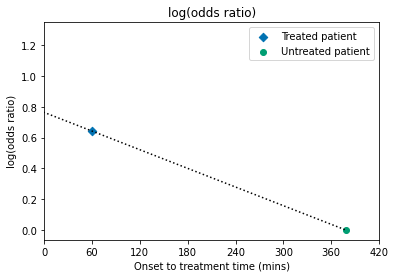

In [12]:
# Mark these two data points:
plt.scatter(x_t1,  y_t1,  label='Treated patient',   marker='D')
plt.scatter(x_tne, y_tne, label='Untreated patient', marker='o')

# Draw a straight line passing through the two points:
plt.plot(x_line, y_line, linestyle=':',color='k')

# Ọther plot setup:
plt.ylabel('log(odds ratio)')
plt.xlabel('Onset to treatment time (mins)')
plt.xlim(0,t_ne*1.1)
plt.xticks(np.arange(0,t_ne+60,60))
plt.legend()
plt.title('log(odds ratio)')
plt.show()

---

## Step 1: Define a straight line model for log(odds ratio)

Here, we want to define log(OR) for mRS$\leq$1 at $t=0$.

We already have the following data points:

+ $ \log\bigl[OR(\mathrm{mRS}\leq 1, t=1\,\mathrm{hr})\bigr] = \log(1.9) $
+ $ \log\bigl[OR(\mathrm{mRS}\leq 1, t=t_{\mathrm{ne}})\bigr] = 0 $

We can connect these two points with a straight line, and then continue the line backwards in time to $t=0$ to find $\log(OR)$ for mRS$\leq$1 at $t=0$. 

We model log(odds ratio) as a straight line, $\log(OR)=a+bt$. 

At $t=t_{\mathrm{ne}}$, we know that $\log\bigl[OR(\mathrm{mRS}, t=t_{\mathrm{ne}})\bigr] = 0 $ and so

$$ a+bt_{\mathrm{ne}} = 0 $$

2: $$ b  = -\frac{a}{t_{\mathrm{ne}}} $$

Then for a generic $t$, we use this $b$ with $a + b t = \log(OR) $ to find $a$. 

$$ 
\begin{align}
a -\frac{a\cdot t}{t_{\mathrm{ne}}} & = \log(OR) \\
a\left(1 - \frac{t}{t_{\mathrm{ne}}}\right) & = \log(OR) \\
\end{align}
$$


3: $$ a = \frac{\log(OR)}{1 - \frac{t}{t_{\mathrm{ne}}}} $$

At $t=1\,$hr,

$$ a = \frac{\log(1.9)}{1 - \frac{1\,\mathrm{hr}}{t_{\mathrm{ne}}\,\mathrm{hr}}} $$

This contains only known values and so we can calculate $a$.

---

## Step 2: Extrapolate from $t=1\,$hr to $t=0\,$hr

Now that we've defined $a$ and $b$, we can use the same straight line equation to find the log(odds ratio) at $t=0$.

At $t=0$, the straight line $a+bt = a +0 = a $ and so:

4: $$ \log\bigl[OR(\mathrm{mRS}\leq1, t=0\,\mathrm{hr})\bigr] = a $$

### Calculate log(OR) for mRS$\leq$1 at $t=0$

> Note that the units of $t$ and $t_{\mathrm{ne}}$ _must_ match here. In the equations above, we have used hours. If we had to use minutes instead, we would use:
$$ a = \frac{\log(1.9)}{1 - \frac{60\,\mathrm{minutes}}{t_{\mathrm{ne}}\,\mathrm{minutes}}} $$ 

Calculate $a$ using time in hours:

In [13]:
a = np.log(OR_mRSleq1_t1) / (1.0 - 1.0/(t_ne/60.0) )

a

0.7629583929973748

In [14]:
# log(OddsRatio)_mRS<=1_time0hr: (leq = "less than or equal to")
logOR_mRSleq1_t0 = a

### Plot the new value

We can compare the newly-calculated log(OR) value with the plot from before:

In [15]:
# Define x and y coordinates of the t=0 point:
x_t0 = 0
y_t0 = logOR_mRSleq1_t0

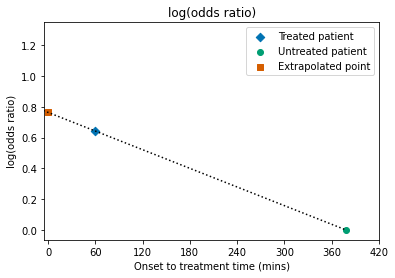

In [16]:
# Mark the data points:
plt.scatter(x_t1,  y_t1,  label='Treated patient',    marker='D')
plt.scatter(x_tne, y_tne, label='Untreated patient',  marker='o')
plt.scatter(x_t0,  y_t0,  label='Extrapolated point', marker='s')

# Draw a straight line connecting the points:
plt.plot(x_line, y_line, linestyle=':',color='k')

# Ọther plot setup:
plt.ylabel('log(odds ratio)')
plt.xlabel('Onset to treatment time (mins)')
plt.xlim(-5,t_ne*1.1)
plt.xticks(np.arange(0,t_ne+60,60))
plt.legend()
plt.title('log(odds ratio)')
plt.show()

---

## Step 3: Convert this log(OR) to probability

Now that we know the log(odds ratio) at $t=0$, we can convert it into probability. From the definition of odds ratio (Equation 1):

5: $$ \frac{P(\mathrm{mRS}\leq 1\ |\ t=0)}{P(\mathrm{mRS}>1\ |\ t=0)}  = OR(\mathrm{mRS}\leq1,t=0) \cdot \left\{ \frac{P(\mathrm{mRS}\leq 1\ |\ t_{\mathrm{ne}})}{P(\mathrm{mRS}>1\ |\ t_{\mathrm{ne}})} \right\} $$

We now know all of the terms on the right hand side. The probability terms are known from the literature data, and from Equation 4:

$$
\begin{align}
    \log\bigl[OR(\mathrm{mRS}\leq1, t=0\,\mathrm{hr})\bigr] & = a \\
    OR(\mathrm{mRS}\leq1, t=0\,\mathrm{hr})\phantom{\bigr]} & = e^a \\
\end{align}
$$

To rearrange Equation 5 to find probability, we'll set $P=P(\mathrm{mRS}\leq 1\ |\ t=0)$ and set the entire right-hand-side of the equation to a new constant $R$:

$$
\begin{align}
\frac{P}{1 - P}  & = R \\
P & = R(1-P) \\
P + (P\cdot R) & = R \\
P(1 + R) & = R \\
P & = \frac{R}{1 + R} \\
\end{align}
$$

This is ugly to write out in full, so we define $P_R = P(\mathrm{mRS}\leq 1\ |\ t_{\mathrm{ne}})$ and use $OR(\mathrm{mRS}\leq1, t=0\,\mathrm{hr})\phantom{\bigr]} = e^a $ so that:

6: $$ P(\mathrm{mRS}\leq 1\ |\ t=0) = \frac{e^{a} \cdot \left\{ \frac{P_{R}}{1 - P_{R}} \right\}}{1 + e^{a} \cdot \left\{ \frac{P_{R}}{1 - P_{R}} \right\}} $$

### Calculate this $P(\mathrm{mRS}\leq 1\ |\ t=0)$

In [17]:
# Probability of mRS<=1 at t=t_ne (a.k.a. probability P_R):
p_mRSleq1_tne = mrs_prob_bins_no_treatment[1]

p_mRSleq1_tne

0.39755312

Calculate $R$, the right-hand-side of Equation 5.

In [18]:
R = np.exp(a) * p_mRSleq1_tne / (1 - p_mRSleq1_tne)

Calculate $P(\mathrm{mRS}\leq 1\ |\ t=0)$ using Equation 6:

In [19]:
p_mRSleq1_t0 = R / (1 + R)

p_mRSleq1_t0

0.5859596403377257

### Plot our known probabilities

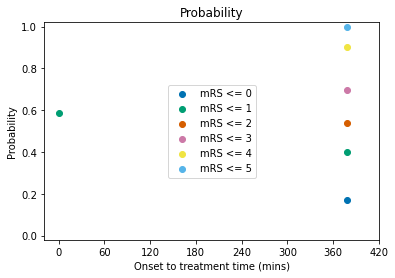

In [20]:
# t_ne data:
for i in range(6):
    s = plt.scatter(t_ne, mrs_prob_bins_no_treatment[i], label=f'mRS <= {i}')
    if i ==1:
        # Newly-found t=0 data:
        plt.scatter(0, p_mRSleq1_t0, color=s.get_facecolor())

        
# Usual plot setup:
plt.ylabel('Probability')
plt.xlabel('Onset to treatment time (mins)')
plt.xticks(np.arange(0,t_ne+60,60))
plt.ylim(-0.02,1.02)
plt.legend(loc='center')
plt.title('Probability')
plt.show()

---

## Step 4: Scale the existing $t=0$ probability distribution for all mRS

Currently we only know one point of the $t=0$ probability distribution, which is the $P(\mathrm{mRS}\leq 1\ |\ t=0)$ that we've just calculated. We will need to expand on this point to create a probability distribution at $t=0$ for all mRS, not just mRS$\leq$1. 

We will base the new distribution on some existing data. In this case, we will use the mRS probability distribution pre-stroke, i.e. at the time just before the onset of stroke. 

### Plot the existing probability distributions:

Since we don't need the time axis from the previous plots, we will plot these probability distributions as a horizontal bar chart.

To save repetition we'll define some functions to draw a stacked bar chart and to draw horizontal arrows <-->.

In [21]:
def draw_horizontal_bar(dist,label=''):
    """
    Draw a stacked horizontal bar chart of the values in 'dist'.
    
    dist  - list or np.array. The probability distribution 
            (non-cumulative).
    label - string. The name printed next to these stacked bars.
    """
    # The first bar will start at this point on the x-axis:
    left = 0
    for i in range(len(dist)):
        # Draw a bar starting from 'left', the end of the previous bar,
        # with a width equal to the probability of this mRS:
        plt.barh(label, width=dist[i], left=left, height=0.3, 
                 label=f'{i}', edgecolor='k')
        # Update 'left' with the width of the current bar so that the 
        # next bar drawn will start in the correct place.    
        left += dist[i]

In [22]:
def draw_horizontal_arrow(x_left,x_right,y,label=''):
    """
    Draw an arrow <-> with a label below it.
    
    x_left, x_right, y - float or int. The coordinates of the arrow.
    label              - string. Optional label to add above the arrow.
    """
    # Draw a horizontal arrow between x_left and x_right at height y:
    plt.annotate('', xy=(x_left,y), xytext=(x_right,y),
                 arrowprops=dict(arrowstyle='<->'))
    # and add a label for the arrow:
    plt.annotate(label, xy=(0.5*(x_left+x_right),y-0.1), ha='center')

Plot the stacked bar charts:

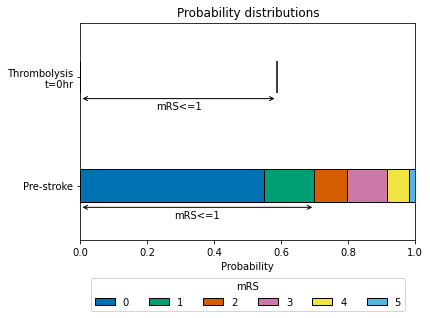

In [23]:
# Draw the pre-stroke distribution: 
draw_horizontal_bar(mrs_prob_dist_t0_treatment_pre, 'Pre-stroke')
# Add legend now to prevent doubling all the labels:
plt.legend(loc='center',ncol=6, title='mRS',
           bbox_to_anchor=[0.5,0.0,0.0,-0.5])   # Legend below axis.

# Set up an empty bar for the t=0 distribution:
draw_horizontal_bar([0.0], 'Thrombolysis'+'\n'+'t=0hr')
# Draw a vertical line where mRS<=1:
plt.scatter(p_mRSleq1_t0, 1.0, marker='|', color='k', s=1000)

# Annotate where mRS<=1.
draw_horizontal_arrow(0.0, p_mRSleq1_t0, y=0.8, label='mRS<=1')
draw_horizontal_arrow(0.0, mrs_prob_bins_t0_treatment_pre[1],
                      y=-0.2, label='mRS<=1')

# Other setup:
plt.xlabel('Probability')
plt.xlim(0,1)
plt.ylim(-0.5,1.5)       
plt.title('Probability distributions')
plt.show()

The point where mRS$\leq$1 is different in each of the distributions. 

### The scaling method

To create the new $t=0$ distribution, we initially want to set $P(\mathrm{mRS}\leq 1, t=0)$ to the newly-calculated value. To find the other mRS values, we start with the pre-stroke bins only and find the size ratio of each mRS bin to the mRS$\leq1$ bin. By carrying the ratios over to the new $t=0$ distribution, we can define the new points.

For example:
+ The pre-stroke mRS<=1 area $G_P$ covers only mRS=0 and mRS=1. 
+ The pre-stroke mRS=0 bin covers some known percentage $G_{P0}$% of the full area $G_P$. 
+ We set the $t=0$ mRS=0 bin to be $G_{P0}$% of the size of the $t=0$ mRS$\leq1$ bin, $G$.

For mRS>1, we instead keep the same size ratio of each bin to the mRS>1 bin. 

### Calculate the scaled distribution

The function that we have written to do this scaling is stored in a package in the `outcome_utilities` directory. 

In [24]:
from outcome_utilities.scale_dist import scale_dist

In [25]:
scale_dist??

Signature: scale_dist(mrs_prob_bins, p_ref, mRS_ref)
Source:   
def scale_dist(mrs_prob_bins,p_ref,mRS_ref):
    """
    Scale an existing probability distribution to a new data point.

    Inputs:
    mrs_prob_bins - list or np.array. Prob. dist to be scaled.
    p_ref         - float. Reference probability.
    mRS_ref       - int. The mRS bin of this reference probability.

    Returns:.
    mrs_prob_dist_sc - np.array. Prob. dist after scaling.
    mrs_prob_bins_sc - np.array. Cumulative prob. dist after scaling.
    """
    # Store the scaled bins in mrs_prob_bins_sc:
    mrs_prob_bins_sc = []

    for mRS in range(6):
        if mRS<=mRS_ref:
            # For the points below the new reference p_ref.
            # Find the size ratio of this bin to the mRS<=mRS_ref bin.
            # When mRS=mRS_ref, ratio=1.
            ratio = mrs_prob_bins[mRS] / mrs_prob_bins[mRS_ref]
            # Scale the bins:
            mrs_prob_bins_sc.append(p_ref * ratio)
        else:
            

$\phantom{gap}$

Use this function to scale our bins:

In [26]:
mrs_prob_dist_t0_treatment, mrs_prob_bins_t0_treatment = (
    scale_dist(mrs_prob_bins_t0_treatment_pre, p_mRSleq1_t0, mRS_ref=1))

In [27]:
mrs_prob_dist_t0_treatment

array([0.46101001, 0.12494963, 0.1346828 , 0.16163172, 0.09212051,
       0.02560534])

In [28]:
mrs_prob_bins_t0_treatment

array([0.46101001, 0.58595964, 0.72064244, 0.88227417, 0.97439468,
       1.00000001])

### Plot the two distributions:

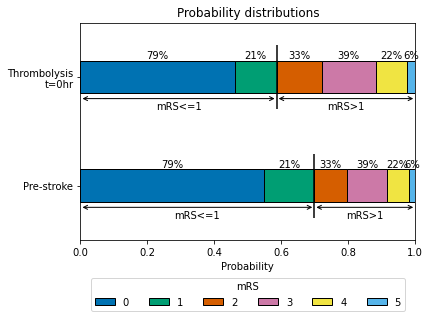

In [29]:
# Draw the pre-stroke distribution: 
draw_horizontal_bar(mrs_prob_dist_t0_treatment_pre, 'Pre-stroke')
# Add legend now to prevent doubling all the labels:
plt.legend(loc='center',ncol=6, title='mRS',
           bbox_to_anchor=[0.5,0.0,0.0,-0.5])   # Legend below axis.

# Draw the t=0 distribution:
draw_horizontal_bar(mrs_prob_dist_t0_treatment, 'Thrombolysis'+'\n'+'t=0hr')

# Add labels:
dists = [mrs_prob_dist_t0_treatment_pre, mrs_prob_dist_t0_treatment]
for i,dist in enumerate(dists):
    # Draw a vertical line where mRS<=1:
    plt.scatter(np.sum(dist[:2]), i, marker='|', color='k', s=4000)
    
    # Annotate where mRS<=1 and mRS>1:
    draw_horizontal_arrow(0.0, np.sum(dist[:2]), y=i-0.2, label='mRS<=1')
    draw_horizontal_arrow(np.sum(dist[:2]), 1.0, y=i-0.2, label='mRS>1')

    for j in range(len(dist)):
        if j<2:
            big_bin_size = np.sum(dist[:2])    # sum of mRS<=1 bins
        else:
            big_bin_size = np.sum(dist[2:])    # sum of mRS>1 bins

        size_ratio = dist[j] / big_bin_size
        
        # Define the middle x-coordinate of the bin: 
        midpoint = np.mean([np.sum(dist[:j]), np.sum(dist[:j+1])])
        
        # Write the percentage size ratio:
        plt.annotate(f'{size_ratio*100:1.0f}%', xy=(midpoint,i+0.2), 
                     ha='center', va='center') # text alignment
    
# Other setup:
plt.xlabel('Probability')
plt.xlim(0,1)
plt.ylim(-0.5,1.5)       
plt.title('Probability distributions')

plt.show()

For example, the mRS=0 bin covers 79% of the combined mRS$\leq$1 bins in the original pre-stroke distribution, and the new scaled $t=0$ keeps this size ratio. Similarly, the mRS=2 bin covers 33% of the combined mRS>1 bins in both cases.

### Plot our known probabilities again

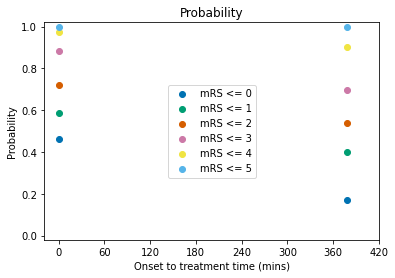

In [30]:
for i in range(6):
    # t_ne data:
    s = plt.scatter(t_ne, mrs_prob_bins_no_treatment[i], label=f'mRS <= {i}')

    # Newly-found t=0 data:
    plt.scatter(0, mrs_prob_bins_t0_treatment[i], color=s.get_facecolor())
    
# Usual plot setup:
plt.ylabel('Probability')
plt.xlabel('Onset to treatment time (mins)')
plt.xticks(np.arange(0,t_ne+60,60))
plt.ylim(-0.02,1.02)
plt.legend(loc='center')
plt.title('Probability')
plt.show()

The newly-defined $t=0$ probability distribution can now be used in the outcome modelling as normal. 

---

## Sidetrack: more general extrapolation

> This section isn't essential for following the thrombolysis $t=0$ example. 

In the current example we have chosen the reference data points at times $t=1$hr and $t=t_{\mathrm{ne}}$, but generally any two times $t=t_1$ and $t=t_2$ could be used so long as we know the following: 

For $t_1$:
+ the time $t_1$, and
+ odds ratio $OR(t=t_1)$.

For $t_2$:
+ the time $t_2$, 
+ odds ratio $OR(t=t_2)$, and
+ probability $P(t=t_2)$ for Step 3.

This is most convenient for $t_2=t_{\mathrm{ne}}$ because we know that $OR(t=t_{\mathrm{ne}})=1$ by definition. Also, $t_1$ can be bigger or smaller than $t_2$. By defining a straight line for log(odds ratio) in the form $a+bt$ we can extrapolate to find the log(odds ratio) at any $t$, not just for $t=0$.

> Important: Make sure the two odds ratios are defined in the same way. Are both using the same baseline at $t=t_\mathrm{ne}$? 

### Find $a$


To find $a$ for two generic data points at times $t_1$ and $t_2$, we write the log(odds ratio) for each:

$$ a + b t_1 = \log(OR_1) $$

$$ a + b t_2 = \log(OR_2) $$

We can combine these by isolating $b$ in each case:

$$ b = \frac{\log(OR_2) - a}{t_2} = \frac{\log(OR_1) - a}{t_1}  $$

And then rearrange to find $a$:

$$
\begin{align}
t_1 \log(OR_2) - t_1 a & = t_2 \log(OR_1) - t_2 a  \\ \\ 
t_2 a - t_1 a & = t_2 \log(OR_1) - t_1 \log(OR_2) \\ \\
a (t_2 - t_1) & = t_2 \log(OR_1) - t_1 \log(OR_2) \\ \\
a & = \frac{t_2 \log(OR_1) - t_1 \log(OR_2)}{t_2 - t_1} \\
\end{align}
$$

To put this into the same form as Equation 3, the $a$ defined for $t=t_\mathrm{ne}$, we multiply the right hand side by $\left(\frac{1}{t_2} \div \frac{1}{t_2}\right)$ which is equal to 1:

7: $$ a = \frac{\log(OR_1) - \frac{t_1}{t_2} \log(OR_2)}{1 - \frac{t_1}{t_2}} $$

When $t_2=t_\mathrm{ne}$, then $\log(OR_2)=0$ by definition and the formula for $a$ matches Equation 3.

### Find $b$

It is straightforward to find $b$ given two values of log(odds ratio) at two times when we know that the two points are connected by a straight line. 

By definition, the gradient $m$ of a straight line $y=m\cdot x+c$ between two coordinates $(x_1, y_1)$ and $(x_2, y_2)$ is:

$$ m = \frac{y_2 - y_1}{x_2 - x_1} $$

So for our straight line of $\log(OR) = a+bt$ with two coordinates $(t_1, \log[OR_1])$ and $(t_2, \log[OR_2])$, we find the gradient:

8: $$ b = \frac{\log(OR_2) - \log(OR_1)}{t_2 - t_1} $$

### General function for steps 1 to 3

We have combined Steps 1 to 3 above into a function `extrapolate_odds_ratio()` that is stored in the `outcome_utilities` directory. The function takes the known times, odds ratios and probabilities, and extrapolates the straight line of log(odds ratio) to a given time $t_e$. It returns the probability and odds ratio at $t_e$ and the constants $a$ and $b$ that make the straight line. 

In [31]:
from outcome_utilities.extrapolate_odds_ratio import extrapolate_odds_ratio

In [32]:
extrapolate_odds_ratio??

Signature: extrapolate_odds_ratio(t_1, OR_1, t_2, OR_2, p_2, t_e=0)
Source:   
def extrapolate_odds_ratio(t_1,OR_1,t_2,OR_2,p_2,t_e=0):
    """
    Use two odds ratios to extrapolate the straight line fit and find
    the odds ratio at a given time, then convert to probability.

    The three time parameters MUST use the same units, e.g. hours.

    Inputs:
    t_1, t_2   - float. Times for data points 1 and 2.
    OR_1, OR_2 - float. Odds ratios at times t_1 and t_2.
    p_2        - float. Probability at time t_2.
    t_e        - float. Time to extrapolate the line to.

    Returns:
    OR_e - float. Extrapolated odds ratio at time t_e.
    p_e  - float. Extrapolated probability at time t_e.
    a, b - float. Constants for the straight line fit a+bt.
    """
    # Calculate "a", the log(odds ratio) at time t=0:
    a = ((np.log(OR_1) - (t_1/t_2)*np.log(OR_2)) /
         (1.0 - (t_1/t_2)) )

    # Calculate "b", the gradient of the log(odds ratio) straight line.
    b = (np.log(OR_2)

$\phantom{gap}$

Check that this gives the same result as for the simplified formulae in Steps 1 to 3:

In [33]:
OR_0, p_0, a_0, b_0 = extrapolate_odds_ratio(
    t_1=60,   OR_1=1.9,                      # t=1hr data
    t_2=t_ne, OR_2=1,   p_2=p_mRSleq1_tne,   # t=t_ne data 
    t_e=0 )                                  # Extrapolate to this time.

In [34]:
print('P:', p_0, p_mRSleq1_t0)
print('a:', a_0, a)
print('b:', b_0, gradient)

P: 0.5859596403377257 0.5859596403377257
a: 0.7629583929973748 0.7629583929973748
b: -0.0020184084470830023 -0.0020184084470830023


---

## References

Emberson J, Lees KR, Lyden P, et al. _Effect of treatment delay, age, and stroke severity on the effects of intravenous thrombolysis with alteplase for acute ischaemic stroke: A meta-analysis of individual patient data from randomised trials_. The Lancet 2014;384:1929–35. doi:10.1016/S0140-6736(14)60584-5

Lees KR, Bluhmki E, von Kummer R, et al. _Time to treatment with intravenous alteplase and outcome in stroke: an updated pooled analysis of ECASS, ATLANTIS, NINDS, and EPITHET trials_. The Lancet 2010;375:1695-703. doi:10.1016/S0140-6736(10)60491-6